### Μαρία Χριστίνα Τσίγκα 1115202100194


# Setup

In [2]:
!pip install datasets nltk plotly seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datasets import load_dataset
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Loading
**Explanation:**  
The code below reads JSON files for each category, parses the review data, and saves it as CSV files. This step ensures our data is in a consistent, tabular format for further analysis.

In [ ]:
OUTPUT_DIR = "csv_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

categories = [
    "Gift_Cards",
    "Subscription_Boxes",
    "Magazine_Subscriptions",
    "Handmade_Products",
    "Health_and_Personal_Care"
]

for category in categories:
    # Load review data
    review_data = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{category}",
        split="full",
        trust_remote_code=True
    )

    # Load metadata
    meta_data = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_meta_{category}",
        split="full",
        trust_remote_code=True,
    )

    # Convert to DataFrames
    review_df = pd.DataFrame(review_data)
    review_df = review_df.rename(columns={'title': 'review_title', 'text':'review_text'})
    meta_df = pd.DataFrame(meta_data)

    # Merge review data with metadata
    merged_df = pd.merge(
        review_df,
        meta_df[['title', 'parent_asin', 'features', 'price', 'average_rating', 'rating_number', 'description', 'categories', 'details']],
        on='parent_asin',
        how='left'
    )

    print(f"Successfully loaded {category} with {len(merged_df)} reviews")
    merged_df.to_csv(f"{category}.csv", index=False)
    print(f"Successfully saved {category}.csv file.")


Successfully loaded Gift_Cards with 152410 reviews
Successfully saved Gift_Cards.csv file.
Successfully loaded Subscription_Boxes with 16216 reviews
Successfully saved Subscription_Boxes.csv file.
Successfully loaded Magazine_Subscriptions with 71497 reviews
Successfully saved Magazine_Subscriptions.csv file.
Successfully loaded Handmade_Products with 664162 reviews
Successfully saved Handmade_Products.csv file.
Successfully loaded Health_and_Personal_Care with 494121 reviews
Successfully saved Health_and_Personal_Care.csv file.


# Data Cleaning
**Explanation:**  
- Missing values are filled or removed to ensure data quality.
- Prices are handled correctly.
- Review texts are cleaned to prepare for text analysis.

In [4]:

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

for category in categories:
    # Clean text data
    df = pd.read_csv(f"{category}.csv", low_memory=False)
    df['cleaned_text'] = df['review_text'].apply(clean_text)

    # Convert types
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')

    # Handle price (convert from string to float)
    df['price'] = df['price'].replace(['None', '—', '-', '', 'nan'], np.nan).infer_objects(copy=False)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

    # Drop rows with missing critical data
    df.dropna(subset=['rating', 'cleaned_text', 'timestamp'], inplace=True)

    print(f"{category}: Cleaned {len(df)} reviews")
    df.to_csv(f"{category}.csv", index=False)
    print(f"Successfully cleaned and saved {category}.csv file.")


Gift_Cards: Cleaned 152410 reviews
Successfully cleaned and saved Gift_Cards.csv file.
Subscription_Boxes: Cleaned 16216 reviews
Successfully cleaned and saved Subscription_Boxes.csv file.
Magazine_Subscriptions: Cleaned 71497 reviews
Successfully cleaned and saved Magazine_Subscriptions.csv file.
Handmade_Products: Cleaned 664162 reviews
Successfully cleaned and saved Handmade_Products.csv file.
Health_and_Personal_Care: Cleaned 494121 reviews
Successfully cleaned and saved Health_and_Personal_Care.csv file.


# Exploratory Analysis
**Results Summary:**  
- The rating distributions show that [insert brief insight, e.g., "most products are rated 4 or 5 stars"].
- Products with many reviews but low ratings may indicate quality issues or controversial items.
- The top 5 best-sellers in each category also have high reviews.
- Ratings over time are steady in average with a lot of noise and not much that can be generalized.



## Star Rating Distributions

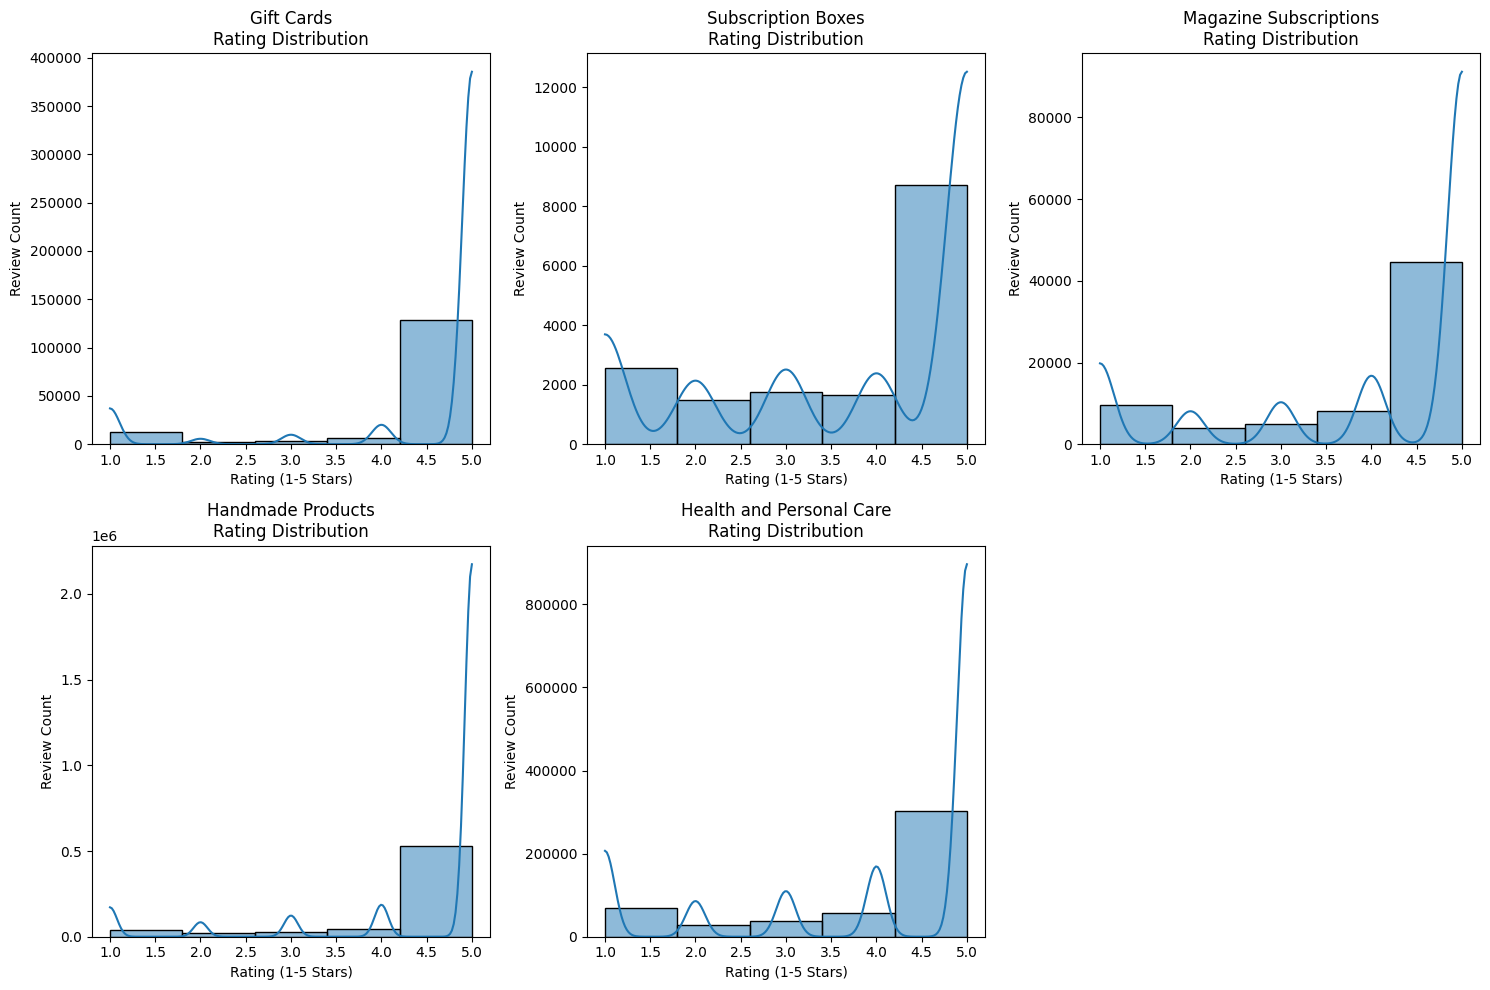

In [5]:
plt.figure(figsize=(15, 10))
for category in categories:
    df = pd.read_csv(f"{category}.csv")
    i = categories.index(category) + 1
    plt.subplot(2, 3, i)
    sns.histplot(df['rating'], bins=5, kde=True)
    plt.title(f"{category.replace('_', ' ')}\nRating Distribution")
    plt.xlabel('Rating (1-5 Stars)')
    plt.ylabel('Review Count')
plt.tight_layout()
plt.show()


# Identify Products with High Reviews but Low Ratings


In [6]:

MIN_REVIEWS = 50  # Threshold for "high reviews"

for category in categories:
    # Group by product and calculate metrics
    df = pd.read_csv(f"{category}.csv")
    product_stats = df.groupby('parent_asin').agg({
        'rating': ['mean', 'count'],
        'title': 'first',  # Product name from metadata
        'price': 'mean'
    }).reset_index()

    product_stats.columns = ['parent_asin', 'avg_rating', 'review_count', 'title', 'avg_price']

    # Filter for problematic products
    problematic = product_stats[
        (product_stats['review_count'] > MIN_REVIEWS) &
        (product_stats['avg_rating'] < 3.0)
    ].sort_values('avg_rating')

    print(f"\n{category.replace('_', ' ')} - Products with High Reviews but Low Ratings:")
    display(problematic[['title', 'avg_rating', 'review_count', 'avg_price']].head(5))




Gift Cards - Products with High Reviews but Low Ratings:


,title,avg_rating,review_count,avg_price
1003,Raising Cane's Gift Card,2.882353,85,50.0
432,Spotify Gift Card,2.951724,145,30.0



Subscription Boxes - Products with High Reviews but Low Ratings:


,title,avg_rating,review_count,avg_price
108,Lip Monthly - Beauty and Makeup Subscription Box,2.440994,161,NaN
22,Candy Club - Delicious Premium Candies Subscri...,2.462687,67,NaN
43,Cairn - Outdoor Subscription Box,2.646154,65,NaN
118,Hunt A Killer - Immersive Murder Mystery Subsc...,2.756303,119,NaN
46,BattlBox - Survival and Outdoor Gear Subscript...,2.924242,66,NaN



Magazine Subscriptions - Products with High Reviews but Low Ratings:


,title,avg_rating,review_count,avg_price
1353,Cookie,2.581818,55,NaN
182,Girls' Life,2.714286,77,NaN
1720,GQ Print Magazine,2.730337,89,NaN
3108,Shape Print Magazine,2.743902,82,NaN
2021,Experience Life,2.801653,121,NaN



Handmade Products - Products with High Reviews but Low Ratings:


,title,avg_rating,review_count,avg_price
102371,Natural Handmade Blue Tiger Eye Bracelet - Sem...,2.377049,61,24.99
156693,Tiny Silver Double Hoop Nose Ring - Spiral Nos...,2.588710,124,9.99
164087,Motivational Wall Art - Office Wall Art & Deco...,2.609524,105,12.95
156691,Tiny Silver Nose Ring hoop - 24 gauge snug Nos...,2.693122,378,9.99
139763,Tiny Gold Nose Ring - Snug 7mm Hoop 18 Gauge P...,2.704918,122,9.99



Health and Personal Care - Products with High Reviews but Low Ratings:


,title,avg_rating,review_count,avg_price
47005,"12 Pack Dish Wand Refills Sponge Heads, Scrub ...",1.166667,66,NaN
49796,1 Dish Wand and 7 Refill Replacement Heads,1.280702,57,NaN
602,Lens CPR Lens Doctor - Repair Scratched And Cl...,1.290323,62,NaN
54859,"CHROM Tooth Polish Uptight White, Instant whit...",1.376147,109,19.9
53887,"Tooth Polish Uptight White, Instant whitening ...",1.438017,121,NaN


# Top 5 Best-Selling Products (by review count)


In [7]:
for category in categories:
    df = pd.read_csv(f"{category}.csv")

    if 'title' not in df.columns:
        print(f"{category}: No 'title' column found.")
        continue

    top_products = (
        df.groupby('title')
        .agg(
            avg_rating=('rating', 'mean'),
            review_count=('title', 'count'),
            avg_price=('price', 'mean')
        )
        .sort_values(by='review_count', ascending=False)
        .head(5)
        .reset_index()
    )

    print(f"\n{category.replace('_', ' ')} - Top 5 Products by Review Count:")
    display(top_products)



Gift Cards - Top 5 Products by Review Count:


,title,avg_rating,review_count,avg_price
0,Amazon Reload,4.565429,43505,NaN
1,Amazon.com Gift Card in a Holiday Gift Box (Va...,4.738264,14912,25.000000
2,Amazon.com Gift Card in Various Gift Boxes,4.579539,6940,25.000000
3,Amazon.com Gift Card in a Reveal (Various Desi...,4.681567,6689,19.730901
4,Amazon.com Gift Card in a Mini Envelope,4.467178,5606,10.000000



Subscription Boxes - Top 5 Products by Review Count:


,title,avg_rating,review_count,avg_price
0,Allure Beauty Box - The Best in Beauty Deliver...,3.760158,1772,NaN
1,Funko Marvel Collector Corps Box,3.564996,1177,NaN
2,KitNipBox | Happy Cat Box | Monthly Cat Subscr...,3.856777,782,NaN
3,TheraBox Self Care Subscription Box - Self Car...,4.421329,572,NaN
4,STEM Club Toy Subscription: 3-4 year olds,4.361468,545,NaN



Magazine Subscriptions - Top 5 Products by Review Count:


,title,avg_rating,review_count,avg_price
0,Family Handyman Print Magazine,4.253943,2473,NaN
1,Reader's Digest Print Magazine,4.342616,2011,NaN
2,National Geographic Magazine,4.303760,1702,NaN
3,Real Simple Print Magazine,4.039315,1577,NaN
4,Popular Science Print Magazine,3.986685,1427,NaN



Handmade Products - Top 5 Products by Review Count:


,title,avg_rating,review_count,avg_price
0,Cats Dogs ID Tags Personalized Lovely Symbols ...,4.664131,2498,9.570000
1,Custom Star Map - Personalized Star Map (Multi...,4.916475,1305,20.970000
2,Personalized Custom Wooden Name Sign - CHARLOT...,4.561757,1093,24.967127
3,The Original BenShot Bullet Rocks Glass with R...,4.920498,1044,19.990000
4,Baby Name Bar id Bracelet Baby Gift Personaliz...,3.552469,972,14.980000



Health and Personal Care - Top 5 Products by Review Count:


,title,avg_rating,review_count,avg_price
0,ASUTRA Natural & Organic Yoga Mat Cleaner (Min...,4.684837,3192,13.99
1,GermGuardian Guardian Technologies GG10002PK G...,3.840745,2901,59.88
2,US Organic 100% Pure Peppermint Essential Oil ...,4.304181,2870,23.99
3,Purple Back Cushion | Pressure Reducing Grid D...,4.047913,2755,59.00
4,"Carlson - The Very Finest Fish Oil, 1600 mg Om...",4.665063,2287,23.80


# Rating Trends Over Time



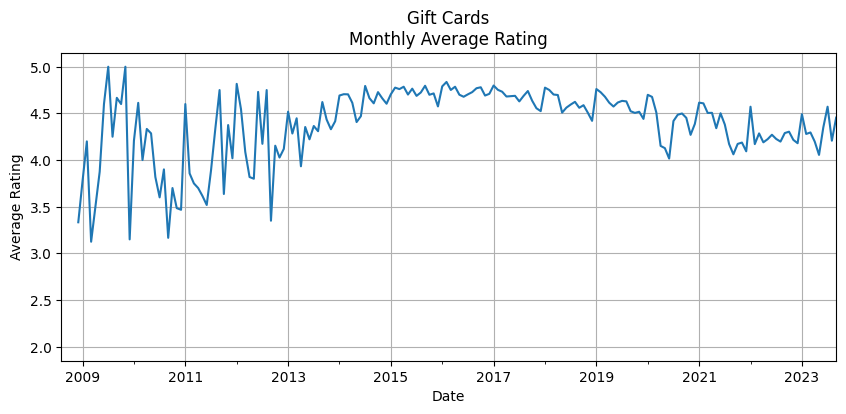

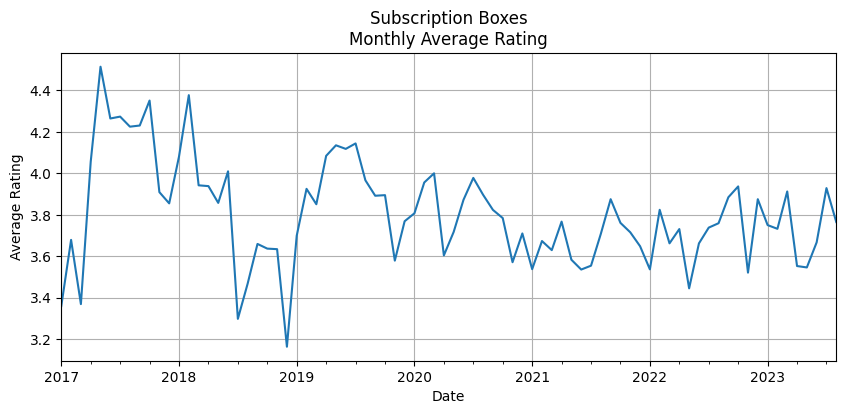

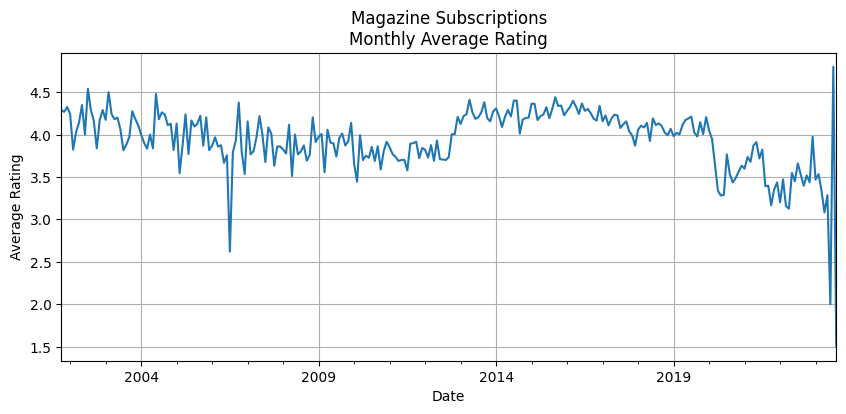

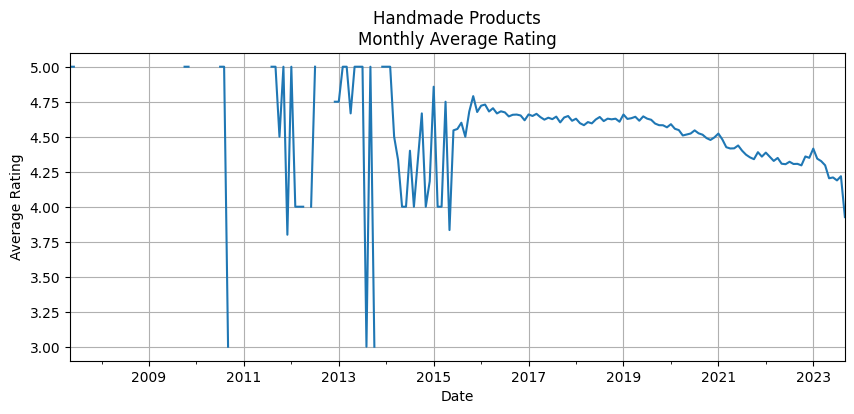

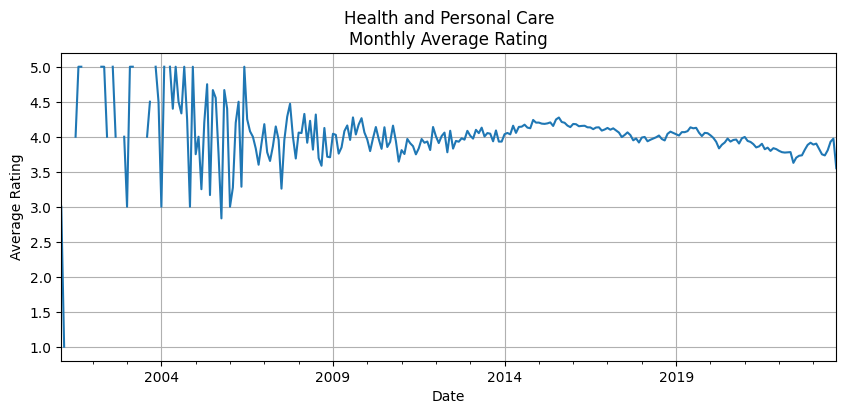

In [8]:
for category in categories:
    df = pd.read_csv(f"{category}.csv")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df[df['timestamp'].notnull()]

    if df.empty:
        print(f"{category}: No valid timestamps.")
        continue

    monthly_avg = df.set_index('timestamp').resample('ME')['rating'].mean()

    if monthly_avg.dropna().empty:
        print(f"{category}: No valid monthly averages.")
        continue

    plt.figure(figsize=(10, 4))
    monthly_avg.plot()
    plt.title(f"{category.replace('_', ' ')}\nMonthly Average Rating")
    plt.xlabel('Date')
    plt.ylabel("Average Rating")
    plt.grid(True)
    plt.show()


# Feature Engineering
**Explanation:**  
This code calculates sentiment scores for each review and combines them with the normalized star rating to create a new feature. This feature can be used for downstream machine learning tasks.
These engineered features may also help improve the performance of machine learning models by providing more granular information about products.

In [9]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

for category in categories:
    # Sentiment Analysis
    df = pd.read_csv(f"{category}.csv")
    df['sentiment'] = df['cleaned_text'].apply(
    lambda x: sia.polarity_scores(str(x))['compound'] if pd.notnull(x) else 0.0)
    print(f"{category}: Added sentiment scores")

    # Normalized Rating (0-1 scale)
    df['norm_rating'] = (df['rating'] - 1) / 4

    # Hybrid Score (weighted average)
    df['hybrid_score'] = 0.6 * df['sentiment'] + 0.4 * df['norm_rating']

    # Price Buckets (for categorical analysis)
    df['price_bucket'] = pd.cut(df['price'],
                               bins=[0, 10, 25, 50, 100, np.inf],
                               labels=['<$10', '$10-25', '$25-50', '$50-100', '>$100'])

    print(f"{category}: Added engineered features")
    df.to_csv(f"{category}.csv", index=False)
    print(f"Successfully saved {category}.csv file.")



Gift_Cards: Added sentiment scores
Gift_Cards: Added engineered features
Successfully saved Gift_Cards.csv file.
Subscription_Boxes: Added sentiment scores
Subscription_Boxes: Added engineered features
Successfully saved Subscription_Boxes.csv file.
Magazine_Subscriptions: Added sentiment scores
Magazine_Subscriptions: Added engineered features
Successfully saved Magazine_Subscriptions.csv file.
Handmade_Products: Added sentiment scores
Handmade_Products: Added engineered features
Successfully saved Handmade_Products.csv file.
Health_and_Personal_Care: Added sentiment scores
Health_and_Personal_Care: Added engineered features
Successfully saved Health_and_Personal_Care.csv file.


# Summary Statistics


In [16]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for category in categories:
    df = pd.read_csv(f"{category}.csv")
    print(f"\n{category.replace('_', ' ')} Summary:")
    print(f"Total Reviews: {len(df)}")
    print(f"Average Rating: {df['rating'].mean():.2f}")
    print(f"Average Sentiment: {df['sentiment'].mean():.2f}")
    print(f"Unique Products: {df['parent_asin'].nunique()}")
    print(f"Price Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")


Gift Cards Summary:
Total Reviews: 152410
Average Rating: 4.55
Average Sentiment: 0.51
Unique Products: 1137
Price Range: $3.99 - $2000.00

Subscription Boxes Summary:
Total Reviews: 16216
Average Rating: 3.77
Average Sentiment: 0.49
Unique Products: 641
Price Range: $nan - $nan

Magazine Subscriptions Summary:
Total Reviews: 71497
Average Rating: 4.04
Average Sentiment: 0.50
Unique Products: 3391
Price Range: $nan - $nan

Handmade Products Summary:
Total Reviews: 664162
Average Rating: 4.50
Average Sentiment: 0.61
Unique Products: 164728
Price Range: $0.01 - $100000.00

Health and Personal Care Summary:
Total Reviews: 494121
Average Rating: 4.00
Average Sentiment: 0.40
Unique Products: 60274
Price Range: $0.10 - $4449.00


# Common words in low-rated reviews (WordCloud)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Gift Cards - Top 20 Words in Low Ratings:


,Word,Frequency
1,card,13465
2,gift,11513
3,amazon,5355
4,cards,4420
5,use,3055
6,get,2443
7,one,2066
8,money,1953
9,would,1856
10,balance,1613


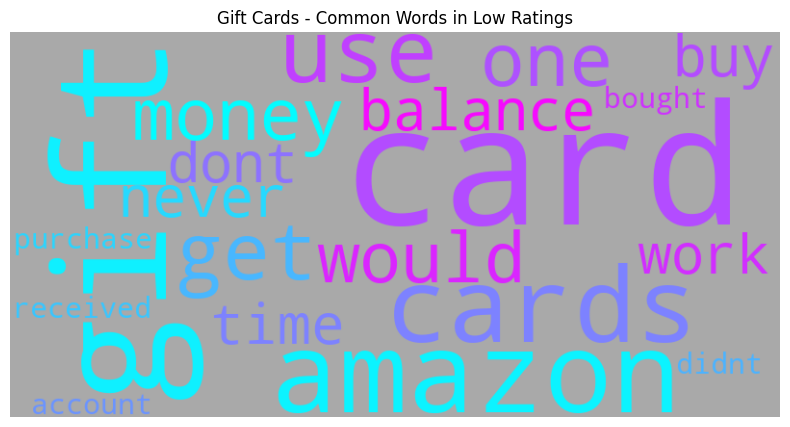


Subscription Boxes - Top 20 Words in Low Ratings:


,Word,Frequency
1,box,3210
2,one,1279
3,subscription,1170
4,like,1143
5,get,952
6,would,936
7,worth,870
8,items,832
9,first,816
10,br,758


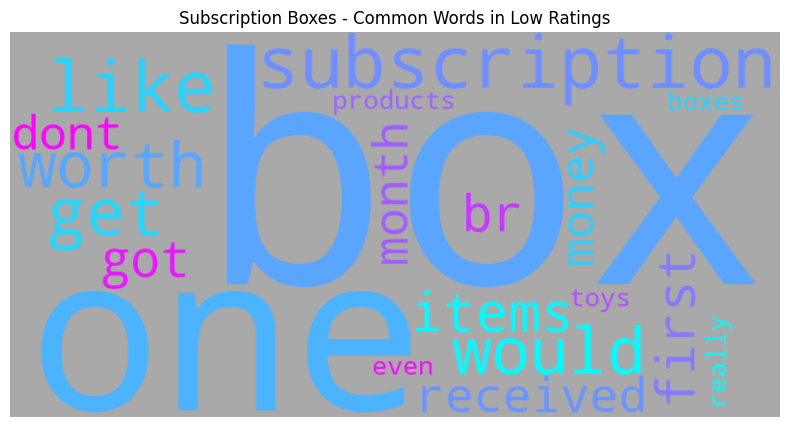


Magazine Subscriptions - Top 20 Words in Low Ratings:


,Word,Frequency
1,magazine,11716
2,subscription,5096
3,issue,3529
4,br,3257
5,one,2901
6,like,2813
7,received,2636
8,get,2549
9,would,2547
10,articles,2166


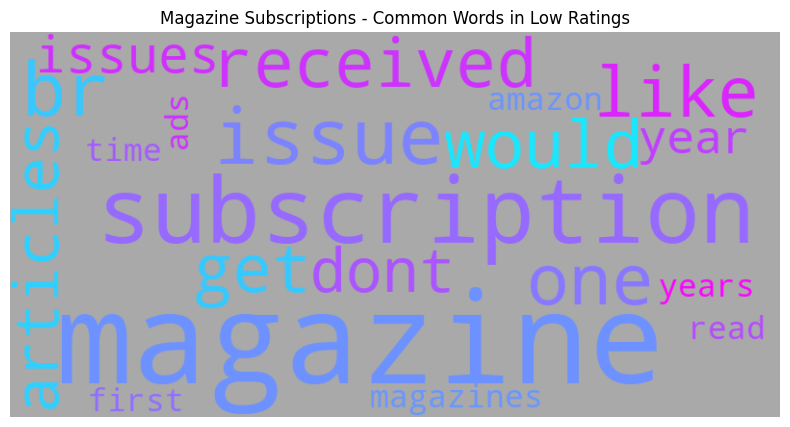


Handmade Products - Top 20 Words in Low Ratings:


,Word,Frequency
1,like,11701
2,would,8583
3,one,7479
4,disappointed,6688
5,small,6458
6,quality,6040
7,product,5703
8,money,5636
9,cheap,5421
10,looks,5022


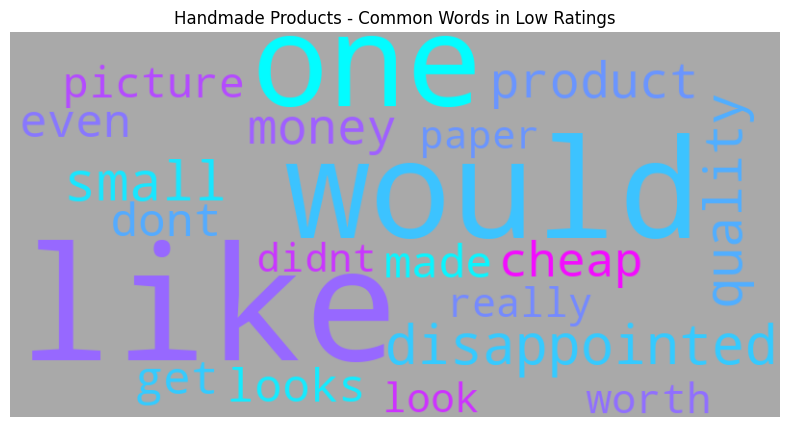


Health and Personal Care - Top 20 Words in Low Ratings:


,Word,Frequency
1,product,21357
2,one,15727
3,like,15670
4,work,14461
5,would,14267
6,use,13326
7,dont,12195
8,get,11553
9,didnt,9979
10,money,9846


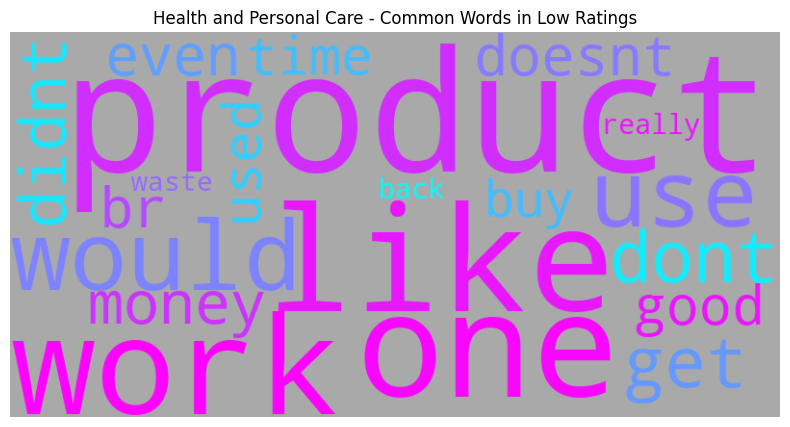

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

for category in categories:
    df = pd.read_csv(f"{category}.csv")
    
    # Filter only reviews with rating lower than 3 (negative sentiment)
    negative_reviews = df[df['rating'] <= 2]['cleaned_text'].dropna()
    
    if negative_reviews.empty:
        print(f"{category}: No low-rated reviews.")
        continue

    # Collect all words from negative reviews
    all_words = []
    for review in negative_reviews:
        all_words.extend(tokenize(review))

    word_counts = Counter(all_words)
    most_common = word_counts.most_common(20)

    print(f"\n{category.replace('_', ' ')} - Top 20 Words in Low Ratings:")
    word_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
    word_df.index = word_df.index + 1  # Make index start from 1
    display(word_df)
    
    # Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='darkgray',
        colormap='cool'
    ).generate_from_frequencies(dict(most_common))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{category.replace('_', ' ')} - Common Words in Low Ratings")
    plt.show()

# Weighted rating per product 

In [18]:
import numpy as np

for category in categories:
    df = pd.read_csv(f"{category}.csv")

    # Group data by product (ASIN)
    product_stats = df.groupby('parent_asin').agg({
        'rating': ['mean', 'count'],
        'title': 'first'  # Use the first title as representative 
    }).reset_index()

    product_stats.columns = ['parent_asin', 'avg_rating', 'review_count', 'title']

    # Weighted Rating = avg_rating * log(review_count + 1)
    product_stats['weighted_rating'] = product_stats['avg_rating'] * np.log1p(product_stats['review_count'])

    print(f"\n{category.replace('_', ' ')} - Top 5 Products by Weighted Rating:")
    display(product_stats.sort_values(by='weighted_rating', ascending=False).head(5))

    product_stats.to_csv(f"{category}_weighted_ratings.csv", index=False)


Gift Cards - Top 5 Products by Weighted Rating:


,parent_asin,avg_rating,review_count,title,weighted_rating
470,B00IX1I3G6,4.604861,36863,Amazon Reload,48.420073
262,B00ADR2LV6,4.738264,14912,Amazon.com Gift Card in a Holiday Gift Box (Various Designs),45.534668
679,B018F4M89S,4.683836,6329,Amazon.com Gift Card in a Reveal (Various Designs),40.997879
899,B077N4CNVJ,4.579539,6940,Amazon.com Gift Card in Various Gift Boxes,40.506943
483,B00JFBLZ90,4.728303,3883,Amazon.com Gift Card in a Birthday Gift Box (Various Designs),39.077630



Subscription Boxes - Top 5 Products by Weighted Rating:


,parent_asin,avg_rating,review_count,title,weighted_rating
87,B07N1572VL,3.760158,1772,Allure Beauty Box - The Best in Beauty Delivered Monthly,28.127592
141,B07VBB4GLM,4.421329,572,"TheraBox Self Care Subscription Box - Self Care Kit With 8 Pampering Products In Wellness Gift Box -Relaxation Care Package, Self Care Gifts For Women",28.079353
0,B01M71IUZ7,4.361468,545,STEM Club Toy Subscription: 3-4 year olds,27.488670
1,B01M7UD21X,4.205761,486,STEM Club Toy Subscription: 8-13 year olds,26.026362
560,B09WC47S3V,3.856777,782,"KitNipBox | Happy Cat Box | Monthly Cat Subscription Boxes Filled with Cat Toys, Kitten Toys, North American Grown Catnip Toys, and Cat Treats",25.698220



Magazine Subscriptions - Top 5 Products by Weighted Rating:


,parent_asin,avg_rating,review_count,title,weighted_rating
142,B00005NIOH,4.336696,1586,National Geographic Magazine,31.959719
2204,B004GVZUUY,4.322954,1381,Reader's Digest Print Magazine,31.260524
1867,B002PXVYEQ,4.198107,1479,Family Handyman Print Magazine,30.645329
244,B000063XJL,4.131086,1068,National Geographic Kids Print Magazine,28.812173
2014,B002PXW1IE,4.066667,1155,Real Simple Print Magazine,28.681066



Handmade Products - Top 5 Products by Weighted Rating:


,parent_asin,avg_rating,review_count,title,weighted_rating
147677,B09GK2JJDZ,4.664131,2498,Cats Dogs ID Tags Personalized Lovely Symbols Pets Collar Name Accessories Simple Custom Engraved Products for Medium Four Legged Child Necklace Chain Anti-Lost Copper Shiny Brass Charm,36.490512
104758,B07RC9FWLN,4.916475,1305,"Custom Star Map - Personalized Star Map (Multiple Sizes - Unframed Star Prints, Star Constellation Map Wall Art, Great Gift - Special Occasion, Engagement Gift, Wedding Gift, Anniversary Gift)",35.274353
14620,B01ASDYQQC,4.920498,1044,The Original BenShot Bullet Rocks Glass with Real .308 Bullet - 11oz | Made in the USA,34.206182
62890,B077J2BF57,4.952790,699,Kitchen Herbs Art Prints - Botanical Prints - (Set of 6) - Unframed - 8x10s,32.446123
72393,B07BSJG8F5,4.961310,672,Woodland Animals Nursery Wall Art Prints (Set of 6) - Unframed - 8x10s,32.306784



Health and Personal Care - Top 5 Products by Weighted Rating:


,parent_asin,avg_rating,review_count,title,weighted_rating
60187,B0C1HHXQ94,4.684837,3192,"ASUTRA Natural & Organic Yoga Mat Cleaner (Mindful Lemongrass Aroma), 4 fl oz | Safe for All Mats & No Slippery Residue | Cleans, Restores, Refreshes | Comes w/Microfiber Cleaning Towel | Deep-Cleansing Natural Cleaner for Fitness Gear & Gym Equipment",37.800621
4329,B004C7MTLA,4.733607,2196,Glycerin Vegetable - 1 Quart (43 oz.) - Non GMO - Sustainable Palm Based - USP - KOSHER - PURE - Pharmaceutical Grade - safety sealed HDPE container with resealable cap,36.424383
4258,B0047VWYSO,4.665063,2287,"Carlson - The Very Finest Fish Oil, 1600 mg Omega-3s, Liquid Fish Oil Supplement, Norwegian Fish Oil, Wild-Caught, Sustainably Sourced Fish Oil Liquid, Lemon, 200ml, 6.7 Fl Oz",36.086287
59039,B0B4328BFW,4.304181,2870,US Organic 100% Pure Peppermint Essential Oil - USDA Certified Organic - 10 ml Pack of 2 - w/Improved caps and droppers (More Size Variations Available),34.271680
60260,B0CB33QW6H,4.622573,1648,"JUNP Hydration Electrolyte Powder, Electrolytes Drink Mix Supplement, Zero Calories Sugar and Carbs, Kosher, Peach Flavor, 90 Servings",34.243670


# Setup (Part 2)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
stop_words = set(stopwords.words('english'))
word_tokenizer = TreebankWordTokenizer()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import gensim.downloader as api
w2v_model = api.load("word2vec-google-news-300")

categories = [
    "Gift_Cards",
    "Subscription_Boxes",
    "Magazine_Subscriptions",
    "Handmade_Products",
    "Health_and_Personal_Care"
]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Clustering for product grouping
**Results Summary:**

* The optimal number of clusters is **varied per category**, as indicated by the elbow method:

  * **Gift\_Cards**: 8 clusters
  * **Magazine\_Subscriptions**: 2 clusters
  * **Handmade\_Products**: 7 clusters
  * **Health\_and\_Personal\_Care**: 2 clusters

* Silhouette scores suggest **good separation for categories with fewer clusters (like Magazine\_Subscriptions and Health\_and\_Personal\_Care), and potentially overlapping or less-defined clusters in more complex segments like Gift\_Cards and Handmade\_Products**.

* Cluster visualization shows:

  * **Gift\_Cards**: Multiple distinct clusters with a wide spread in PCA space, indicating diverse customer behavior.
  * **Magazine\_Subscriptions** and **Health\_and\_Personal\_Care**: Clear binary separation with compact groupings, suggesting simpler or more polarized customer preferences.
  * **Handmade\_Products**: More varied clustering with some overlap, possibly due to nuanced or overlapping product features/preferences.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Category: Gift_Cards
Gift_Cards - Loaded 152410 rows
Best k: 8 (silhouette=0.500)


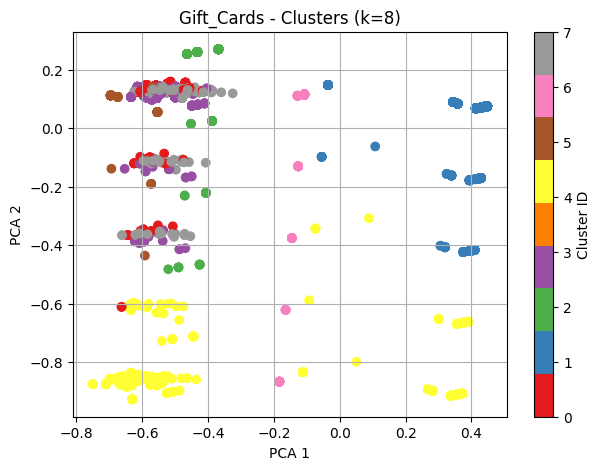


Average price and rating per cluster:
   cluster  price  rating
0        0   0.15    0.97
1        1   0.07    0.98
2        2   0.10    0.97
3        3   0.29    0.98
4        4   0.16    0.04
5        5   0.73    0.99
6        6   0.01    0.90
7        7   0.14    0.98

Top words per Cluster:
Cluster 0: food, applebees, like, restaurant, gift
Cluster 1: amazoncom, gift, card, item, perfect
Cluster 2: gift, card, million, sale, wait
Cluster 3: gift, card, store, online, purchase
Cluster 4: gift, card, amazoncom, item, give
Cluster 5: bread, gift, jcpenney, panera, offer
Cluster 6: card, amazoncom, gift, envelope, delivered
Cluster 7: gift, card, beauty, state, brand

Category: Subscription_Boxes
Subscription_Boxes - Loaded 16216 rows
Skipping category Subscription_Boxes due to empty data.

Category: Magazine_Subscriptions
Magazine_Subscriptions - Loaded 71497 rows
Best k: 2 (silhouette=0.135)


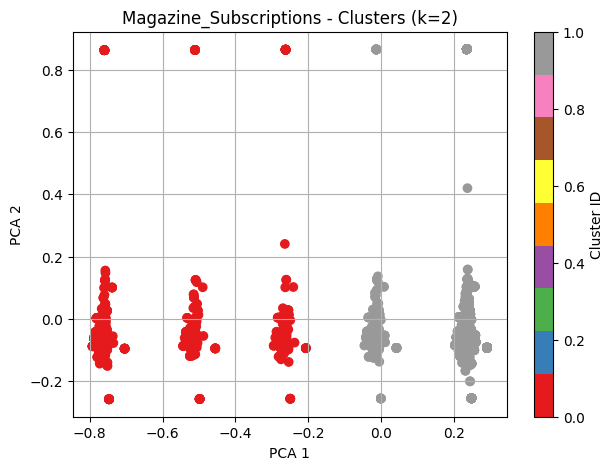


Average price and rating per cluster:
   cluster  price  rating
0        0    0.0    0.19
1        1    0.0    0.96

Top words per Cluster:
Cluster 0: magazine, reader, issue, world, tip
Cluster 1: magazine, reader, issue, world, tip

Category: Handmade_Products
Handmade_Products - Loaded 664162 rows
Best k: 7 (silhouette=0.047)


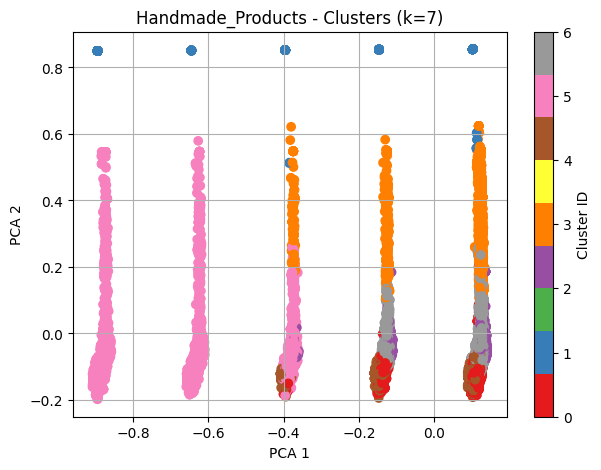


Average price and rating per cluster:
   cluster  price  rating
0        0   0.01    0.97
1        1   0.00    0.83
2        2   0.01    0.98
3        3   0.00    0.97
4        4   0.01    0.95
5        5   0.01    0.21
6        6   0.01    0.98

Top words per Cluster:
Cluster 0: silver, earring, gift, necklace, sterling
Cluster 1: print, unframed, 8x10, set, nature
Cluster 2: decal, sign, wall, color, vinyl
Cluster 3: print, frame, art, gift, page
Cluster 4: ring, size, silver, gold, sterling
Cluster 5: gift, size, made, color, please
Cluster 6: gift, made, size, color, inch

Category: Health_and_Personal_Care
Health_and_Personal_Care - Loaded 494121 rows
Best k: 2 (silhouette=0.127)


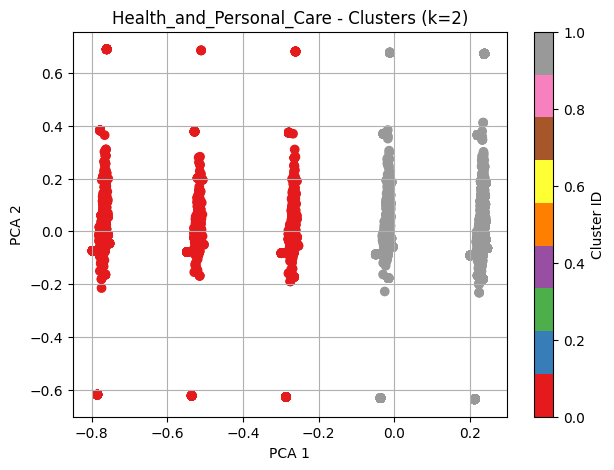


Average price and rating per cluster:
   cluster  price  rating
0        0    0.0    0.19
1        1    0.0    0.96

Top words per Cluster:
Cluster 0: use, product, skin, natural, oil
Cluster 1: use, product, skin, natural, oil


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Lowercase and remove punctuation
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', "", text)
    tokens = text.split()
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 2:
            lemma = lemmatizer.lemmatize(word)
            cleaned_tokens.append(lemma)

    return ' '.join(cleaned_tokens)

# Create TF-IDF and numeric feature arrays
def prepare_features(df):
    df['description'] = df['description'].fillna('').apply(preprocess_text)
    df = df[df['description'].str.strip().astype(bool)]

    if df.empty:
        return None, None, None, df 

    df.loc[:, 'price'] = df['price'].fillna(0)
    df.loc[:, 'rating'] = df['rating'].fillna(0)
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[['price', 'rating']])
    df.loc[:, 'price'] = scaled_values[:, 0]
    df.loc[:, 'rating'] = scaled_values[:, 1]

    # Convert descriptions to TF-IDF vectors 
    tfidf = TfidfVectorizer(max_features=700)
    tfidf_matrix = tfidf.fit_transform(df['description'])
    tfidf_array = tfidf_matrix.toarray()
    numeric = df[['price', 'rating']].values

    return tfidf_array, numeric, tfidf.get_feature_names_out(), df

for category in categories:
    print(f"\nCategory: {category}")
    df = pd.read_csv(f"{category}.csv")
    print(f"{category} - Loaded {len(df)} rows")
    df = df.sample(frac=0.1, random_state=10)

    tfidf_matrix, numeric_features, feature_names, df = prepare_features(df)
    if tfidf_matrix is None or df.empty:
        print(f"Skipping category {category} due to empty data.")
        continue

    # Combine TF-IDF and numeric features 
    combined_features = np.hstack([tfidf_matrix, numeric_features])

    # Reduce to 2D for plotting 
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(combined_features)

    # Find best k using silhouette score 
    best_score = -1
    best_k = 2
    for k in range(2, 9):
        model = KMeans(n_clusters=k, random_state=10)
        labels = model.fit_predict(combined_features)
        score = silhouette_score(combined_features, labels)
        if score > best_score:
            best_score = score
            best_k = k

    print(f"Best k: {best_k} (silhouette={best_score:.3f})")

    # Final KMeans clustering 
    model = KMeans(n_clusters=best_k, random_state=10)
    df['cluster'] = model.fit_predict(combined_features)

    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='Set1')
    plt.colorbar(scatter, label='Cluster ID')
    plt.title(f"{category} - Clusters (k={best_k})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

    print("\nAverage price and rating per cluster:")
    cluster_summary = df.groupby('cluster')[['price', 'rating']].mean().round(2).reset_index()
    print(cluster_summary)

    print("\nTop words per Cluster:")
    for cluster_id in sorted(df['cluster'].unique()):
        texts = df[df['cluster'] == cluster_id]['description']
        words = [w for w in ' '.join(texts).split() if w not in stop_words]
        common = pd.Series(words).value_counts().head(5)
        print(f"Cluster {cluster_id}: {', '.join(common.index)}") 

# Content-Based Filtering with Word2Vec

**Explanation:**
In this section, we implement a **content-based recommendation system** using Word2Vec embeddings. The main steps are:

* **Text Preprocessing:** Product descriptions and titles are cleaned, lowercased, and tokenized. Stopwords and short words are removed, and lemmatization is applied to standardize word forms.
* **Vectorization:** Each product is represented by averaging the Word2Vec embeddings of the valid tokens in its combined description and title.
* **Feature Augmentation:** The normalized product price is appended to the vector representation to include pricing information in the similarity calculation.
* **Similarity Calculation:** We compute cosine similarity between product vectors. Additionally, a TF-IDF representation of the product text is created and combined with the Word2Vec-based similarity using a weighted average (70% Word2Vec, 30% TF-IDF) to form a hybrid similarity score.
* **Recommendation:** For a randomly selected product, we recommend the top 5 most similar items (excluding itself), based on the hybrid similarity score.

This approach enables recommending items with semantically similar content, even in the absence of user interaction data.



In [21]:
pd.set_option('display.max_colwidth', None)

def tokenize_text(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', "", text)
    tokens = text.split()
    return [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

rows = []
for category in categories:
    df = pd.read_csv(f"{category}.csv", usecols=['asin', 'title', 'price', 'description'])
    df = df.dropna()
    df['category'] = category
    for _, row in df.iterrows():
        # Emphasize the description
        full = f"{row['description']} {row['description']} {row['title']}"
        tokens = tokenize_text(full)  # From previous cell
        if len(tokens) > 3:
            rows.append([row['asin'], row['title'], row['price'], tokens, category])

# Create single DataFrame
df = pd.DataFrame(rows, columns=['asin', 'title', 'price', 'tokens', 'category'])
df = df.drop_duplicates(subset='title').reset_index(drop=True)

# Normalize price
df['price'] = df['price'].fillna(0)
df['text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
df['price_norm'] = MinMaxScaler().fit_transform(df[['price']])

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert tokens to vectors
vectors = []
for tokens in df['tokens']:
    valid = [t for t in tokens if t in w2v_model]
    if len(valid) < 3:
        vec = np.random.normal(0, 0.01, 300)
    else:
        vec = np.mean([w2v_model[w] for w in valid], axis=0)
    vectors.append(vec)

# Combine vectors with normalized price
X = np.hstack([vectors, df[['price_norm']].values])

idx = random.randint(0, len(df) - 1)
print(f"\nSelected: {df.loc[idx, 'title']} ({df.loc[idx, 'category']})")

# Calculate similarities
sim_w2v = cosine_similarity([X[idx]], X)[0]
sim_tfidf = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
# Hybrid similarity: weighted average of Word2Vec and TF-IDF
hybrid_sim = 0.7 * sim_w2v + 0.3 * sim_tfidf

#Avoid recommending the same product
selected_title = df.loc[idx, 'title'].lower()
top5 = []
for i in hybrid_sim.argsort()[::-1]:
    if i == idx or df.loc[i, 'title'].lower() == selected_title:
        continue
    top5.append(i)
    if len(top5) == 5:
        break

print("\nTop 5 similar products:")
for i in top5:
    print(f"- {df.loc[i, 'title']} | {df.loc[i, 'category']} | Score: {hybrid_sim[i]:.3f}")


Selected: The Ten Commandments Exodus 20 Vinyl Wall Decal Sticker (Handmade_Products)

Top 5 similar products:
- Movie Inspired Wizard Vinyl Decal Sane Vinyl Wall Decal V1 Sticker Lettering Nursery Bedroom | Handmade_Products | Score: 0.658
- Custom Name Decal - Vinyl Decal Sticker | Handmade_Products | Score: 0.652
- And I Think To Myself What A Wonderful World Vinyl Wall Decal Sticker | Handmade_Products | Score: 0.651
- Namaste Vinyl Wall Decal Sticker Buddha yoga Decal | Handmade_Products | Score: 0.644
- This Kitchen Is Seasoned With Love Vinyl Wall Decal Sticker | Handmade_Products | Score: 0.637


# User-Based and Item-Based recommendation
**Explanation:**
Here, we build **collaborative filtering** recommendation systems using two approaches:

* **User-Based Collaborative Filtering:**

  * Identifies users with similar rating behaviors using cosine similarity.
  * Recommends products that those similar users rated highly but the target user hasn't rated.

* **Item-Based Collaborative Filtering:**

  * Detects similarities between items based on user rating patterns.
  * Recommends items that are similar to those the user has already interacted with.

**Key Steps:**

* A user-item rating matrix is constructed using the review data.
* Similarity matrices are computed (for both users and items) using cosine similarity.
* For each target user, predicted ratings are calculated for unrated items by aggregating the ratings of similar users or items.
* A **hybrid model** combines these predictions with content-based filtering scores (based on product descriptions, Word2Vec vectors, and normalized price) to improve recommendations—especially for sparse datasets or new products.

---

**Results Summary:**

* **User-based collaborative filtering** works well when sufficient overlap in user behavior exists and can recover highly rated unseen items.
* **Item-based collaborative filtering** is more robust to sparse user-item matrices and captures item similarity more consistently.
* **Hybrid recommendations** (combining collaborative and content-based scores) balance user history with item semantics and pricing, improving personalization.



In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Clean and vectorize
def preprocess(text):
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text.lower())
    return [w for w in word_tokenizer.tokenize(text) if w not in stop_words and w in w2v_model]

#Convert tokens to Word2Vec vector
def vectorize(tokens):
    if len(tokens) < 3:
        return np.random.normal(0, 0.01, 300)
    return np.mean([w2v_model[t] for t in tokens], axis=0)

def content_based(df_meta):
    df_meta.dropna(inplace=True)
    df_meta.drop_duplicates(subset='parent_asin', inplace=True)

    if df_meta.empty:
        return pd.Series(dtype=float), None, None

    # Normalize price
    df_meta['price'] = df_meta['price'].fillna(0)
    df_meta['price_norm'] = MinMaxScaler().fit_transform(df_meta[['price']])
    df_meta['text'] = df_meta['title'] + " " + df_meta['description'] # Combine title and description as text input
    df_meta['tokens'] = df_meta['text'].apply(preprocess)
    #Convert each product to a combined vector (Word2Vec + price)
    df_meta['vec'] = df_meta.apply(lambda row: np.append(vectorize(row['tokens']), row['price_norm']), axis=1)
    
    try:
        vectors = np.stack(df_meta['vec'].to_numpy())
    except ValueError:
        return pd.Series(dtype=float), None, None

    idx = random.randint(0, len(df_meta) - 1)
    asin = df_meta.iloc[idx]['parent_asin']
    sim = cosine_similarity([vectors[idx]], vectors)[0]
    cbf_scores = pd.Series(sim, index=df_meta['parent_asin']).groupby(level=0).max()
    return cbf_scores, asin, idx

def collaborative_filtering(df_ratings, user_id):
    matrix = df_ratings.pivot_table(index='user_id', columns='parent_asin', values='rating', fill_value=0)
    
    # User-based
    user_sim = cosine_similarity(matrix)
    np.fill_diagonal(user_sim, 0)  # Ignore self-similarity
    sim_df = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
    neighbors = sim_df.loc[user_id].nlargest(5).index
    weighted = matrix.loc[neighbors].T.dot(sim_df.loc[user_id, neighbors])
    pred_user = weighted / (sim_df.loc[user_id, neighbors].sum() + 1e-9)
    
    # Item-based
    item_sim = cosine_similarity(matrix.T)
    np.fill_diagonal(item_sim, 0)
    item_sim_df = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
    ratings = matrix.loc[user_id]
    pred_item = {
        item: (sims * ratings[sims.index]).sum() / abs(sims).sum()
        for item in matrix.columns if ratings[item] == 0
        if (sims := item_sim_df[item].nlargest(5)).sum() != 0
    }

    return pred_user, pd.Series(pred_item)

for cat in categories:
    print(f"\n====== Category: {cat} ======")

    try:
        df_ratings = pd.read_csv(f"{cat}.csv", usecols=['user_id', 'parent_asin', 'rating']).dropna()
    except Exception:
        print("Ratings file error.")
        continue
    
    df_ratings['rating'] = df_ratings['rating'].astype(float)
    # Keep top users and items only
    top_users = df_ratings['user_id'].value_counts().head(5000).index
    top_items = df_ratings['parent_asin'].value_counts().head(1000).index
    df_ratings = df_ratings[df_ratings['user_id'].isin(top_users) & df_ratings['parent_asin'].isin(top_items)]
    if df_ratings.empty:
        print("Not enough data after filtering.")
        continue

    user = random.choice(df_ratings['user_id'].unique())

    # CF
    preds_u, preds_i = collaborative_filtering(df_ratings, user)

    # CBF
    df_meta = pd.read_csv(f"{cat}.csv", usecols=['parent_asin', 'title', 'description', 'price'])
    cbf_scores, target_asin, idx = content_based(df_meta)
    if cbf_scores.empty:
        print("Skipping CBF due to vector issues.")
        continue

    # Hybrid
    common = preds_i.index.intersection(cbf_scores.index)
    if not common.empty:
        # Normalize CF and CBF scores to 0–1 range
        cf_norm = (preds_i[common] - preds_i.min()) / (preds_i.max() - preds_i.min() + 1e-9)
        cbf_norm = (cbf_scores[common] - cbf_scores.min()) / (cbf_scores.max() - cbf_scores.min() + 1e-9)
        hybrid = 0.7 * cf_norm + 0.3 * cbf_norm
    else:
        hybrid = pd.Series(dtype=float)

    print(f"\nUser: {user} | Target ASIN: {target_asin}")
    print("\nUser-Based CF Top-5:")
    display(preds_u.sort_values(ascending=False).head(5))
    print("\nItem-Based CF Top-5:")
    display(preds_i.sort_values(ascending=False).head(5))
    if not hybrid.empty:
        print("\nHybrid Top-5 Recommendations:")
        display(hybrid.sort_values(ascending=False).head(5))
    else:
        print("\nHybrid: No common items found.")



====== Category: Gift_Cards ======

User: AGIJS4XZDII3IHQZHITINQJ4L7YA | Target ASIN: B07GH6WX29

User-Based CF Top-5:


parent_asin
B018F4M89S    5.0
B00JFBLZ90    5.0
B01M24FWQE    0.0
B01K8RLQ48    0.0
B01K8RM59S    0.0
dtype: float64


Item-Based CF Top-5:


B01FERR1VE    5.000000
B0091JKZYW    5.000000
B00CHQ7I2S    3.049132
B07193NS22    2.724200
B01E4QPH4O    2.495250
dtype: float64


Hybrid Top-5 Recommendations:


B00ADR2LV6    0.528789
B071X4ZX3X    0.527895
B0BT85F69N    0.525935
B00K4PITIQ    0.481634
B077N4CNVJ    0.478311
dtype: float64


====== Category: Subscription_Boxes ======
Skipping CBF due to vector issues.

====== Category: Magazine_Subscriptions ======
Skipping CBF due to vector issues.

====== Category: Handmade_Products ======

User: AFHE333P3CN6EUUO2BUU42SOYHFA | Target ASIN: B09B7WMQMB

User-Based CF Top-5:


parent_asin
B078PTVYXV    5.000000
B07C5CV85P    1.830127
B071NNLLJ8    1.830127
B01591IOQG    0.000000
B093C5D76P    0.000000
dtype: float64


Item-Based CF Top-5:


B071NNLLJ8    2.508278
B07C5CV85P    1.795748
B01591IOQG    0.000000
B093XQLHXS    0.000000
B096R5QZHV    0.000000
dtype: float64


Hybrid Top-5 Recommendations:


B071NNLLJ8    0.952243
B07C5CV85P    0.661301
B018RKPZ86    0.265485
B01CEM02EA    0.265248
B01LXUTUAV    0.265068
dtype: float64


====== Category: Health_and_Personal_Care ======

User: AF3KK6JYBVGTFZMQW43VAS7RTNUA | Target ASIN: B00T4V6WVM

User-Based CF Top-5:


parent_asin
B01JH8VAV8    4.666667
B07G9MTFX8    0.000000
B07GTL6R6G    0.000000
B07H2ZXC2R    0.000000
B07H4LC1HB    0.000000
dtype: float64


Item-Based CF Top-5:


614847932X    0.0
B07CPJJMLZ    0.0
B07BZVJDNB    0.0
B07C2BBM1L    0.0
B07C8D64F1    0.0
dtype: float64


Hybrid Top-5 Recommendations:


B0CDDBK2G4    0.224522
B08W5FL1BT    0.222412
B095JJDCX7    0.218911
B001FOLMR0    0.218770
B08WJ9B6BK    0.218045
dtype: float64

# Sentiment analysis


**Explanation:**
In this section, we perform **sentiment analysis** on product reviews to classify their polarity (positive, negative, or neutral). The process involves:

* **Text Preprocessing:** Review texts are cleaned by lowercasing, removing punctuation, and filtering out stopwords. Tokenization is performed using NLTK's `TreebankWordTokenizer`.
* **Feature Extraction:** Reviews are converted into numerical features using three strategies:

  * **TF-IDF**: Captures term importance in the corpus.
  * **Word2Vec**: Uses pretrained embeddings to represent semantic similarity.
  * **Word2Vec + Numerical Features**: Appends normalized metadata (e.g., review length, rating, verification status) to improve classification.
* **Model Training:** Several classifiers are trained, including:

  * **Naive Bayes** (only for TF-IDF due to vector requirements),
  * **K-Nearest Neighbors (KNN)**,
  * **Random Forest**, and
  * **Support Vector Machines (SVM)**.
* **Evaluation:** Models are evaluated using 10-fold cross-validation and tested on a held-out test set using metrics like **accuracy**, **precision**, **recall**, and **F1-score**.

**Results Summary:**

* The best-performing model varies by product category, demonstrating the importance of category-specific tuning:

  * **Subscription\_Boxes**: *Random Forest* — F1 Score: **0.5221**
  * **Gift\_Cards**: *KNN* — F1 Score: **0.5428**
  * **Health\_and\_Personal\_Care**: *Random Forest* — F1 Score: **0.4828**
  * **Magazine\_Subscriptions**: *SVM* — F1 Score: **0.5136**
  * **Handmade\_Products**: *SVM* — F1 Score: **0.5839**
* Feature augmentation (e.g., combining Word2Vec with numerical metadata) often improved model performance.
* The comparative results were saved as CSV files for further analysis and reporting.

These findings highlight that **SVM and Random Forest consistently perform well** for this task and that blending content features with contextual numerical data enhances sentiment classification in real-world review datasets.



In [23]:
import json
import pandas as pd
import numpy as np
import json
import os
import requests
import string
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from collections import Counter
import gensim.downloader as api
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
w2v_model = api.load("glove-wiki-gigaword-100")
tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))

categories = [
    "Gift_Cards",
    "Subscription_Boxes",
    "Magazine_Subscriptions",
    "Handmade_Products",
    "Health_and_Personal_Care"
]

os.makedirs("amazon_data", exist_ok=True)

file_urls = {
    "Gift_Cards": "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/Gift_Cards.jsonl",
    "Subscription_Boxes": "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/Subscription_Boxes.jsonl",
    "Magazine_Subscriptions": "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/Magazine_Subscriptions.jsonl",
    "Handmade_Products": "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/Handmade_Products.jsonl",
    "Health_and_Personal_Care": "https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/Health_and_Personal_Care.jsonl"
}

for name, url in file_urls.items():
    filepath = f"amazon_data/{name}.jsonl"
    if not os.path.exists(filepath):
        print(f"Downloading {name}.jsonl...")
        response = requests.get(url)
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"Saved {filepath}")
    else:
        print(f"{filepath} already exists. Skipping download.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


amazon_data/Gift_Cards.jsonl already exists. Skipping download.
amazon_data/Subscription_Boxes.jsonl already exists. Skipping download.
amazon_data/Magazine_Subscriptions.jsonl already exists. Skipping download.
amazon_data/Handmade_Products.jsonl already exists. Skipping download.
amazon_data/Health_and_Personal_Care.jsonl already exists. Skipping download.


In [13]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler

def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = [json.loads(line) for line in f]
    return pd.DataFrame(lines)

# Convert star ratings into sentiment labels
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

# Clean and tokenize the review text
def clean(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = tokenizer.tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

# Balance the dataset by sampling sentiment labels in a 3:1:1 ratio(positive:neutral:negative)
def balance_sentiment_dataset(df, max_samples=None):
    counts = {'positive': 0, 'neutral': 0, 'negative': 0}
    texts, labels = [], []

    for _, row in df.iterrows():
        label = row['sentiment']
        if (label == 'positive' and counts[label] < 3) or (counts[label] < 1):
            texts.append(row['text'])
            labels.append(label)
            counts[label] += 1
        if sum(counts.values()) == 5:
            counts = dict.fromkeys(counts, 0)
        if len(texts) >= max_samples:
            break

    return pd.DataFrame({'text': texts, 'sentiment': labels})

def vectorize_w2v(text):
    tokens = text.split()
    vecs = [w2v_model[word] for word in tokens if word in w2v_model]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

def evaluate_test(X_train, X_test, y_train, y_test, model_dict, feature_set):
    results = []
    for name, model in model_dict.items():
        if "Word2Vec" in feature_set and name == "Naive Bayes":
            continue
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        results.append({
            "Feature Set": feature_set,
            "Model": name,
            "Precision": precision_score(y_test, pred, average='macro', zero_division=0),
            "Recall": recall_score(y_test, pred, average='macro', zero_division=0),
            "F1-Score": f1_score(y_test, pred, average='macro', zero_division=0),
            "Accuracy": accuracy_score(y_test, pred)
        })
    return results

#Perform 10-fold cross-validation on the training data
def evaluate_cv(X, y, models, feature_set):
    results = []
    for name, model in models.items():
        if "Word2Vec" in feature_set and name == "Naive Bayes":
            continue
        scores = cross_validate(model, X, y, cv=10, scoring=['precision_macro', 'recall_macro', 'f1_macro', 'accuracy'])
        results.append({
            "Feature Set": feature_set,
            "Model": name,
            "Precision": scores['test_precision_macro'].mean(),
            "Recall": scores['test_recall_macro'].mean(),
            "F1-Score": scores['test_f1_macro'].mean(),
            "Accuracy": scores['test_accuracy'].mean()
        })
    return results

models = {
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

for cat in categories:
    print(f"\nCategory: {cat}")
    path = f'amazon_data/{cat}.jsonl'
    df = read_jsonl(path)
    df = df[['rating', 'text']].dropna()
    df = df[df['text'].str.len() > 10]
    df['sentiment'] = df['rating'].apply(label_sentiment)

    df['review_length'] = df['text'].apply(lambda x: len(x.split()))
    df['verified'] = 0

    balanced_df = balance_sentiment_dataset(df, max_samples=3000)
    balanced_df['review_length'] = balanced_df['text'].apply(lambda x: len(x.split()))
    balanced_df['rating'] = 5
    balanced_df['verified'] = 0
    numerical_features = MinMaxScaler().fit_transform(balanced_df[['rating', 'review_length', 'verified']])

    X = balanced_df['text'].apply(clean)
    y = balanced_df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # TF-IDF
    tfidf = TfidfVectorizer()
    X_tfidf_train = tfidf.fit_transform(X_train)
    X_tfidf_test = tfidf.transform(X_test)
    # Word2Vec
    X_w2v_train = np.vstack(X_train.apply(vectorize_w2v))
    X_w2v_test = np.vstack(X_test.apply(vectorize_w2v))
    # Word2Vec + numerical features
    X_w2v_full = np.hstack([X_w2v_train, numerical_features[:len(X_w2v_train)]])
    X_w2v_test_full = np.hstack([X_w2v_test, numerical_features[len(X_w2v_train):]])

    print(f"\nCross-validation results: {cat}")
    cv_results_tfidf = evaluate_cv(X_tfidf_train, y_train, models, "TF-IDF")
    cv_results_w2v = evaluate_cv(X_w2v_train, y_train, models, "Word2Vec")
    cv_results_w2v_aug = evaluate_cv(X_w2v_full, y_train, models, "Word2Vec+Numerical")
    cv_results_df = pd.DataFrame(cv_results_tfidf + cv_results_w2v + cv_results_w2v_aug)
    display(cv_results_df)

    print(f"\nFinal test set evaluation: {cat}")
    test_results_tfidf = evaluate_test(X_tfidf_train, X_tfidf_test, y_train, y_test, models, "TF-IDF")
    test_results_w2v = evaluate_test(X_w2v_train, X_w2v_test, y_train, y_test, models, "Word2Vec")
    test_results_w2v_aug = evaluate_test(X_w2v_full, X_w2v_test_full, y_train, y_test, models, "Word2Vec+Numerical")
    test_results_df = pd.DataFrame(test_results_tfidf + test_results_w2v + test_results_w2v_aug)
    display(test_results_df)

    cv_results_df.to_csv(f"{cat}_cv_results.csv", index=False)
    test_results_df.to_csv(f"{cat}_test_results.csv", index=False)
    print(f"Results saved for category: {cat}")

    best_model = test_results_df.loc[test_results_df['F1-Score'].idxmax()]
    print(f"\nBest model for {cat}: {best_model['Model']} with F1-Score = {best_model['F1-Score']:.4f}")


Category: Gift_Cards

Cross-validation results: Gift_Cards


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.721868,0.417316,0.394138,0.640000
1,TF-IDF,KNN,0.527892,0.417446,0.405375,0.621667
2,TF-IDF,Random Forest,0.592186,0.510037,0.512440,0.675000
3,TF-IDF,SVM,0.655522,0.532817,0.537877,0.700000
4,Word2Vec,KNN,0.534310,0.551455,0.534782,0.617500
5,Word2Vec,Random Forest,0.577847,0.523171,0.520984,0.678333
6,Word2Vec,SVM,0.609655,0.569774,0.561912,0.702917
7,Word2Vec+Numerical,KNN,0.534286,0.550925,0.533826,0.618333
8,Word2Vec+Numerical,Random Forest,0.569978,0.515892,0.514805,0.677083
9,Word2Vec+Numerical,SVM,0.610163,0.569122,0.561578,0.702500



Final test set evaluation: Gift_Cards


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.801459,0.438738,0.429141,0.693333
1,TF-IDF,KNN,0.529026,0.416077,0.413215,0.671667
2,TF-IDF,Random Forest,0.537695,0.509782,0.505766,0.708333
3,TF-IDF,SVM,0.614291,0.540850,0.534264,0.731667
4,Word2Vec,KNN,0.540257,0.566186,0.541410,0.655000
5,Word2Vec,Random Forest,0.539891,0.496319,0.494532,0.693333
6,Word2Vec,SVM,0.541162,0.540786,0.521608,0.711667
7,Word2Vec+Numerical,KNN,0.541424,0.568658,0.542796,0.655000
8,Word2Vec+Numerical,Random Forest,0.566004,0.511818,0.517400,0.698333
9,Word2Vec+Numerical,SVM,0.541162,0.540786,0.521608,0.711667


Results saved for category: Gift_Cards

Best model for Gift_Cards: KNN with F1-Score = 0.5428

Category: Subscription_Boxes

Cross-validation results: Subscription_Boxes


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.364631,0.338819,0.258993,0.593750
1,TF-IDF,KNN,0.506607,0.468807,0.471677,0.628333
2,TF-IDF,Random Forest,0.617295,0.472564,0.474341,0.665000
3,TF-IDF,SVM,0.589635,0.457572,0.453245,0.657917
4,Word2Vec,KNN,0.455533,0.454483,0.453594,0.567917
5,Word2Vec,Random Forest,0.552125,0.436543,0.422521,0.640417
6,Word2Vec,SVM,0.550603,0.455375,0.430825,0.652083
7,Word2Vec+Numerical,KNN,0.458342,0.457637,0.456678,0.568750
8,Word2Vec+Numerical,Random Forest,0.532807,0.436691,0.422726,0.637500
9,Word2Vec+Numerical,SVM,0.543825,0.455140,0.430476,0.651667



Final test set evaluation: Subscription_Boxes


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.546823,0.336207,0.265977,0.640000
1,TF-IDF,KNN,0.524530,0.478139,0.489584,0.666667
2,TF-IDF,Random Forest,0.631497,0.503264,0.522132,0.716667
3,TF-IDF,SVM,0.655357,0.486221,0.504508,0.713333
4,Word2Vec,KNN,0.453336,0.459730,0.455835,0.591667
5,Word2Vec,Random Forest,0.520803,0.448208,0.450932,0.678333
6,Word2Vec,SVM,0.502616,0.451559,0.441840,0.685000
7,Word2Vec+Numerical,KNN,0.444870,0.450945,0.447222,0.583333
8,Word2Vec+Numerical,Random Forest,0.570503,0.459456,0.460293,0.690000
9,Word2Vec+Numerical,SVM,0.502616,0.451559,0.441840,0.685000


Results saved for category: Subscription_Boxes

Best model for Subscription_Boxes: Random Forest with F1-Score = 0.5221

Category: Magazine_Subscriptions

Cross-validation results: Magazine_Subscriptions


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.450316,0.342556,0.268426,0.602500
1,TF-IDF,KNN,0.569161,0.503486,0.513035,0.665417
2,TF-IDF,Random Forest,0.608810,0.457971,0.462120,0.658333
3,TF-IDF,SVM,0.627443,0.462711,0.468806,0.663750
4,Word2Vec,KNN,0.501546,0.515630,0.501018,0.597083
5,Word2Vec,Random Forest,0.549773,0.464901,0.463847,0.654583
6,Word2Vec,SVM,0.581641,0.489325,0.486047,0.667500
7,Word2Vec+Numerical,KNN,0.499921,0.513310,0.498934,0.595417
8,Word2Vec+Numerical,Random Forest,0.548900,0.461817,0.459841,0.648750
9,Word2Vec+Numerical,SVM,0.581436,0.488645,0.485067,0.667083



Final test set evaluation: Magazine_Subscriptions


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.705042,0.344231,0.275229,0.616667
1,TF-IDF,KNN,0.532569,0.481789,0.492027,0.653333
2,TF-IDF,Random Forest,0.649641,0.486573,0.503767,0.693333
3,TF-IDF,SVM,0.614543,0.476419,0.488287,0.686667
4,Word2Vec,KNN,0.507070,0.521171,0.510085,0.620000
5,Word2Vec,Random Forest,0.543666,0.461374,0.465021,0.665000
6,Word2Vec,SVM,0.627916,0.506414,0.513579,0.696667
7,Word2Vec+Numerical,KNN,0.504498,0.517427,0.507272,0.615000
8,Word2Vec+Numerical,Random Forest,0.597489,0.469672,0.479337,0.676667
9,Word2Vec+Numerical,SVM,0.627916,0.506414,0.513579,0.696667


Results saved for category: Magazine_Subscriptions

Best model for Magazine_Subscriptions: SVM with F1-Score = 0.5136

Category: Handmade_Products

Cross-validation results: Handmade_Products


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.600441,0.360116,0.301563,0.611250
1,TF-IDF,KNN,0.557627,0.523380,0.529671,0.669583
2,TF-IDF,Random Forest,0.612724,0.508680,0.518056,0.689167
3,TF-IDF,SVM,0.678333,0.498485,0.511838,0.689583
4,Word2Vec,KNN,0.516586,0.509611,0.511447,0.616250
5,Word2Vec,Random Forest,0.594407,0.488791,0.496340,0.671667
6,Word2Vec,SVM,0.597979,0.522597,0.530291,0.685417
7,Word2Vec+Numerical,KNN,0.511251,0.503688,0.505257,0.611250
8,Word2Vec+Numerical,Random Forest,0.599351,0.483664,0.492452,0.669167
9,Word2Vec+Numerical,SVM,0.599971,0.523525,0.531499,0.686250



Final test set evaluation: Handmade_Products


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.794883,0.368337,0.322704,0.638333
1,TF-IDF,KNN,0.576365,0.548342,0.555988,0.696667
2,TF-IDF,Random Forest,0.692943,0.547253,0.574987,0.733333
3,TF-IDF,SVM,0.701529,0.552754,0.583879,0.733333
4,Word2Vec,KNN,0.543338,0.537738,0.540021,0.661667
5,Word2Vec,Random Forest,0.606679,0.517433,0.534107,0.700000
6,Word2Vec,SVM,0.611893,0.560406,0.571924,0.718333
7,Word2Vec+Numerical,KNN,0.536922,0.532826,0.534479,0.656667
8,Word2Vec+Numerical,Random Forest,0.592162,0.515997,0.522437,0.705000
9,Word2Vec+Numerical,SVM,0.611893,0.560406,0.571924,0.718333


Results saved for category: Handmade_Products

Best model for Handmade_Products: SVM with F1-Score = 0.5839

Category: Health_and_Personal_Care

Cross-validation results: Health_and_Personal_Care


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.464939,0.340830,0.263182,0.596667
1,TF-IDF,KNN,0.454256,0.415076,0.406938,0.600833
2,TF-IDF,Random Forest,0.643450,0.443060,0.437724,0.650417
3,TF-IDF,SVM,0.669839,0.397125,0.365766,0.629167
4,Word2Vec,KNN,0.441684,0.421871,0.421826,0.562917
5,Word2Vec,Random Forest,0.496378,0.403876,0.377757,0.622917
6,Word2Vec,SVM,0.502617,0.400146,0.365213,0.624167
7,Word2Vec+Numerical,KNN,0.442151,0.421869,0.421915,0.562917
8,Word2Vec+Numerical,Random Forest,0.496536,0.396843,0.367960,0.619167
9,Word2Vec+Numerical,SVM,0.502617,0.400146,0.365213,0.624167



Final test set evaluation: Health_and_Personal_Care


,Feature Set,Model,Precision,Recall,F1-Score,Accuracy
0,TF-IDF,Naive Bayes,0.544593,0.339339,0.270414,0.635000
1,TF-IDF,KNN,0.520619,0.461267,0.468200,0.660000
2,TF-IDF,Random Forest,0.598385,0.475663,0.482809,0.691667
3,TF-IDF,SVM,0.680481,0.432528,0.433255,0.678333
4,Word2Vec,KNN,0.414455,0.411532,0.408708,0.590000
5,Word2Vec,Random Forest,0.558386,0.403509,0.390990,0.651667
6,Word2Vec,SVM,0.780556,0.414318,0.395785,0.668333
7,Word2Vec+Numerical,KNN,0.411670,0.408529,0.405738,0.588333
8,Word2Vec+Numerical,Random Forest,0.455733,0.383162,0.361999,0.633333
9,Word2Vec+Numerical,SVM,0.775467,0.414318,0.395283,0.668333


Results saved for category: Health_and_Personal_Care

Best model for Health_and_Personal_Care: Random Forest with F1-Score = 0.4828
